In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [113]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [114]:
df = pd.read_csv("AER_credit_card_data.csv")
df['card'] = (df['card'] == "yes").astype(int)
df['reports'] = -df['reports']
df['dependents'] = -df['dependents']
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,-3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,-3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,-4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,-2,64,1,5


In [115]:
from sklearn.model_selection import train_test_split
df_full_train,df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train,df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

In [116]:
len(df_train),len(df_val),len(df_test)

(791, 264, 264)

# Q1

In [117]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

features = ['reports','dependents','active','share']

reports feature auc is 0.717
dependents feature auc is 0.533
active feature auc is 0.604
share feature auc is 0.989


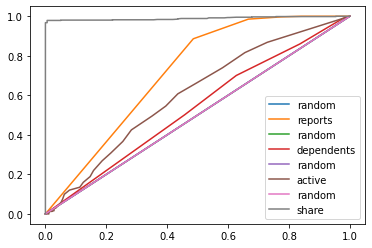

In [118]:
for col in features:
    fpr,tpr,t = roc_curve(df_train.card,df_train[col])
    plt.plot([0,1],[0,1],label ="random")
    plt.plot(fpr, tpr,label =col)
    plt.legend()
    print('%s feature auc is %.3f' % (col,auc(fpr,tpr)))

# Q2

In [119]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [120]:
def train(df_train,df_val, C = 1.0):
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.iloc[:,df_train.columns!='card'].to_dict(orient = 'records')
    val_dict = df_val.iloc[:,df_val.columns!='card'].to_dict(orient = 'records')

    
    X_train = dv.fit_transform(train_dict)
    X_val = dv.fit_transform(val_dict)

    y_train = df_train.card
    y_val = df_val.card
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)
    
    y_pred = model.predict_proba(X_val)
        
    return y_val, y_pred

In [121]:
y_val,y_pred = train(df_train,df_val)

In [122]:
roc_auc_score(y_val,y_pred[:,1]),

(0.995171242063847,)

# Q3

In [123]:
threshold = np.linspace(0,1,100).round(2)

In [124]:
ROC_list=[]

for t in threshold:
    
    predict_positiv = (y_pred[:,1] >= t)
    predict_negativ = (y_pred[:,1] < t)
    actual_positiv = (y_val == 1) 
    actual_negativ = (y_val == 0) 

    FP = (predict_positiv & actual_negativ).sum()
    TP = (predict_positiv & actual_positiv).sum()
    FN = (predict_negativ & actual_positiv).sum()
    TN = (predict_negativ & actual_negativ).sum()

    ROC_list.append((t,TP,TN,FP,FN))

In [125]:
roc_df = pd.DataFrame(ROC_list, columns = ['t','TP','TN','FP','FN'])
roc_df['fpr'] = roc_df.FP / (roc_df.FP + roc_df.TN)
roc_df['tpr'] = roc_df.TP / (roc_df.TP + roc_df.FN)
roc_df['precision'] = roc_df.TP / (roc_df.TP + roc_df.FP)
roc_df['recall'] = roc_df.TP / (roc_df.TP + roc_df.FN)

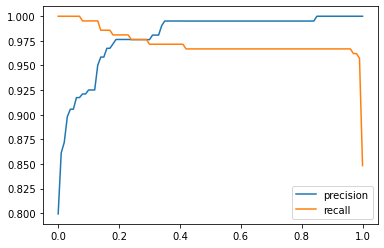

In [126]:
plt.plot(roc_df.t,roc_df.precision, label = 'precision')
plt.plot(roc_df.t,roc_df.recall, label = 'recall')
plt.legend()

In [127]:
'0.3'

'0.3'

# Q4

In [128]:
roc_df['F1'] = 2 * roc_df.precision * roc_df.recall / (roc_df.precision + roc_df.recall)

In [129]:
roc_df['F1'].max()

0.9832134292565947

In [130]:
roc_df[roc_df['F1']==roc_df['F1'].max()]

,t,TP,TN,FP,FN,fpr,tpr,precision,recall,F1
35,0.35,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213
36,0.36,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213
37,0.37,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213
38,0.38,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213
39,0.39,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213
40,0.40,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213
41,0.41,205,52,1,6,0.018868,0.971564,0.995146,0.971564,0.983213


In [131]:
't = 0.4'

't = 0.4'

# Q5

In [132]:
from sklearn.model_selection import KFold

In [133]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [134]:
roc_auc_list = []

for train_idx, val_idx in \
            kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_val,y_pred = train(df_train,df_val)
    roc_auc_list.append(roc_auc_score(y_val,y_pred[:,1]))

In [135]:
np.std(roc_auc_list)

0.0027434713804377724

# Q6

In [152]:
from tqdm.auto import tqdm

c_dict = {}

for c in tqdm([0.01,0.1,1,10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    roc_auc_list = []

    for train_idx, val_idx in \
                kfold.split(df_full_train):

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_val,y_pred = train(df_train,df_val,c)
        roc_auc_list.append(roc_auc_score(y_val,y_pred[:,1]))
        
    print('C=%s have a mean of %.5f and a std of %.3f' % (c,np.mean(roc_auc_list),np.std(roc_auc_list)))
    
    c_dict[c] = roc_auc_list

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 have a mean of 0.99188 and a std of 0.006
C=0.1 have a mean of 0.99506 and a std of 0.004
C=1 have a mean of 0.99645 and a std of 0.003
C=10 have a mean of 0.99639 and a std of 0.003


In [153]:
'C=1'

'C=1'